# Импорт библиотек и настройка темы графиков.

In [114]:
import pandas as pd, seaborn as sns, xgboost as xgb

from scipy.stats import trim_mean, median_abs_deviation
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error, mean_absolute_error

sns.set_theme(context = 'paper', style = 'whitegrid', 
              palette = 'dark', font_scale = 2, rc = {'figure.figsize': (20, 5)})

# Загрузка данных данные.

In [115]:
df_data = pd.read_csv('ВС DS Сбер data.csv', delimiter = ';')
df_usd = pd.read_csv('USD.csv')
df_euro = pd.read_csv('Euro.csv')
df_sp500 = pd.read_csv('sp500.csv', usecols = ['Date', 'Close/Last'])
df_kr = pd.read_csv('Key rate and inflation.csv', usecols = ['дата', 'Ключевая ставка. % годовых'])
df_wage = pd.read_csv('Wage.csv')

# Правка данных.
## df_data.

In [116]:
df_data.columns = ['Report date', 'Value']
df_data['Report date'] = pd.to_datetime(df_data['Report date'], infer_datetime_format = True)
df_data.set_index('Report date', inplace = True)

df_data.shape

(2111, 1)

## df_usd.

In [117]:
df_usd.columns = ['Report date', 'USD']
df_usd['Report date'] = pd.to_datetime(df_usd['Report date'], infer_datetime_format = True)
df_usd['USD'].astype(float)

df_usd_train = df_usd[(df_usd['Report date'] >= pd.to_datetime('2013-12-30')) &
                      (df_usd['Report date'] <= pd.to_datetime('2019-10-10'))]

df_usd_train.set_index('Report date', inplace = True)

df_usd_train.shape

(1426, 1)

## df_euro.

In [118]:
df_euro.columns = ['Report date', 'Euro']
df_euro['Report date'] = pd.to_datetime(df_euro['Report date'], infer_datetime_format = True)
df_euro['Euro'].astype(float)

df_euro_train = df_euro[(df_euro['Report date'] >= pd.to_datetime('2013-12-30')) &
                        (df_euro['Report date'] <= pd.to_datetime('2019-10-10'))]

df_euro_train.set_index('Report date', inplace = True)

df_euro_train.shape

(1426, 1)

## df_sp500.

In [119]:
df_sp500.columns = ['Report date', 'S&P 500']
df_sp500['Report date'] = pd.to_datetime(df_sp500['Report date'], infer_datetime_format = True)
df_sp500['S&P 500'].astype(float)

df_sp500_train = df_sp500[(df_sp500['Report date'] >= pd.to_datetime('2013-12-30')) &
                          (df_sp500['Report date'] <= pd.to_datetime('2019-10-10'))]

df_sp500_train.set_index('Report date', inplace = True)

df_sp500_train.shape

(1474, 1)

## df_kr.

In [120]:
df_kr.columns = ['Key rate', 'Report date']
df_kr['Report date'] = pd.to_datetime(df_kr['Report date'], dayfirst = True)
df_kr['Key rate'].astype(float)

df_kr_train = df_kr[(df_kr['Report date'] >= pd.to_datetime('2013-12-01')) &
                    (df_kr['Report date'] <= pd.to_datetime('2019-10-01'))]

df_kr_train.set_index('Report date', inplace = True)

df_kr_train.shape

(71, 1)

## df_wage.

In [121]:
df_wage.columns = ['Report date', 'Wage']
df_wage['Report date'] = pd.to_datetime(df_wage['Report date'], dayfirst = True)
df_wage['Wage'].astype(float)

df_wage_train = df_wage[(df_wage['Report date'] >= pd.to_datetime('2013-12-01')) &
                        (df_wage['Report date'] <= pd.to_datetime('2019-10-01'))]

df_wage_train.set_index('Report date', inplace = True)

df_wage_train.shape

(71, 1)

## Связка всех данных в один датафрейм.

In [122]:
df_features_train = df_usd_train.join([df_euro_train, df_sp500_train, df_kr_train, df_wage_train], how = 'outer')

df_features_train.shape

(1785, 5)

In [123]:
df_train = df_data.join(df_features_train)

print(df_train.shape)
df_train.head()

(2111, 6)


,Value,USD,Euro,S&P 500,Key rate,Wage
Report date,,,,,,
2013-12-30,3457625638,NaN,NaN,1841.07,NaN,NaN
2013-12-31,3417092149,32.7292,44.9699,1848.36,NaN,NaN
2014-01-01,3417092149,32.6587,45.0559,1848.36,5.5,29535.0
2014-01-02,3417092149,NaN,NaN,1831.98,NaN,NaN
2014-01-03,3417092149,NaN,NaN,1831.37,NaN,NaN


## Визуализация объёма средств.

<AxesSubplot: xlabel='Report date', ylabel='Value'>

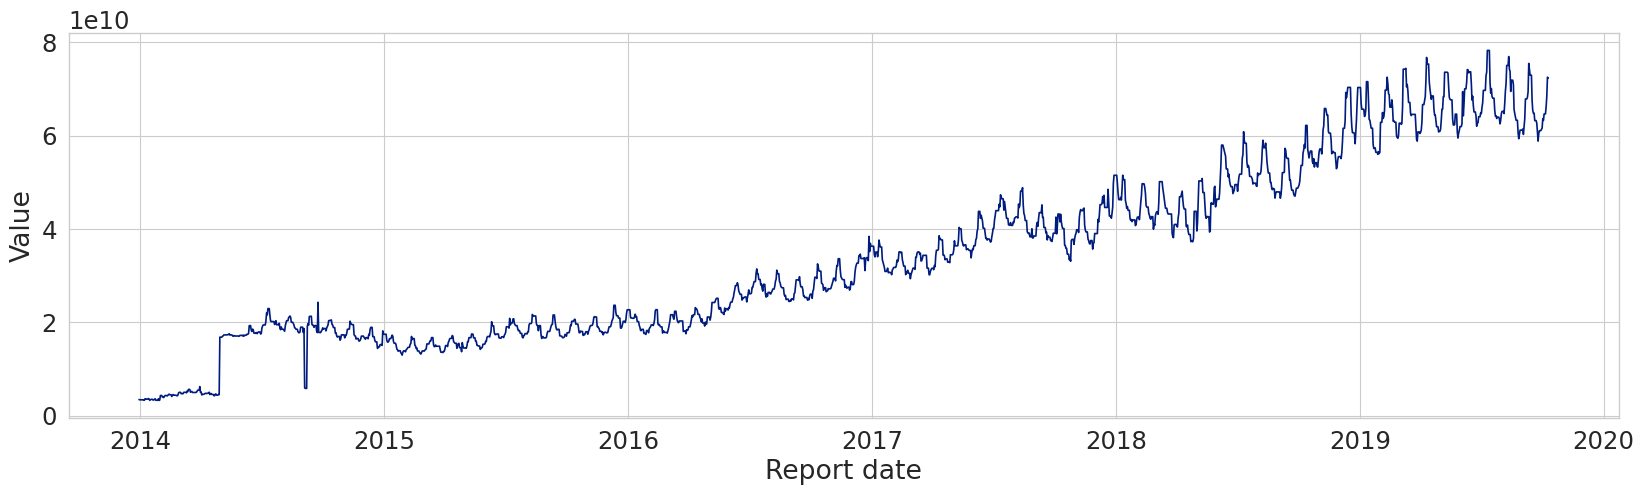

In [124]:
sns.lineplot(data = df_train['Value'])

# Исследовательский анализ данных по объёму средств.

## Мера центральной тенденции.

In [125]:
trimmed_mean = trim_mean(a = df_train['Value'], proportiontocut = .1)
print(f"Trimmed mean = {trimmed_mean}\nMean = {df_train['Value'].mean()}\nMedian = {df_train['Value'].median()}")

Trimmed mean = 32751604974.354057
Mean = 33896676186.65798
Median = 30213521890.0


## Дисперсия данных.

In [126]:
MAD = median_abs_deviation(x = df_train['Value'])
print(f"MAD = {MAD}\nVariance = {df_train['Value'].var()}\nStandard deviation = {df_train['Value'].std()}")

MAD = 12872115091.0
Variance = 3.517402079323293e+20
Standard deviation = 18754738279.494312


## Распределение данных.

<AxesSubplot: xlabel='Value'>

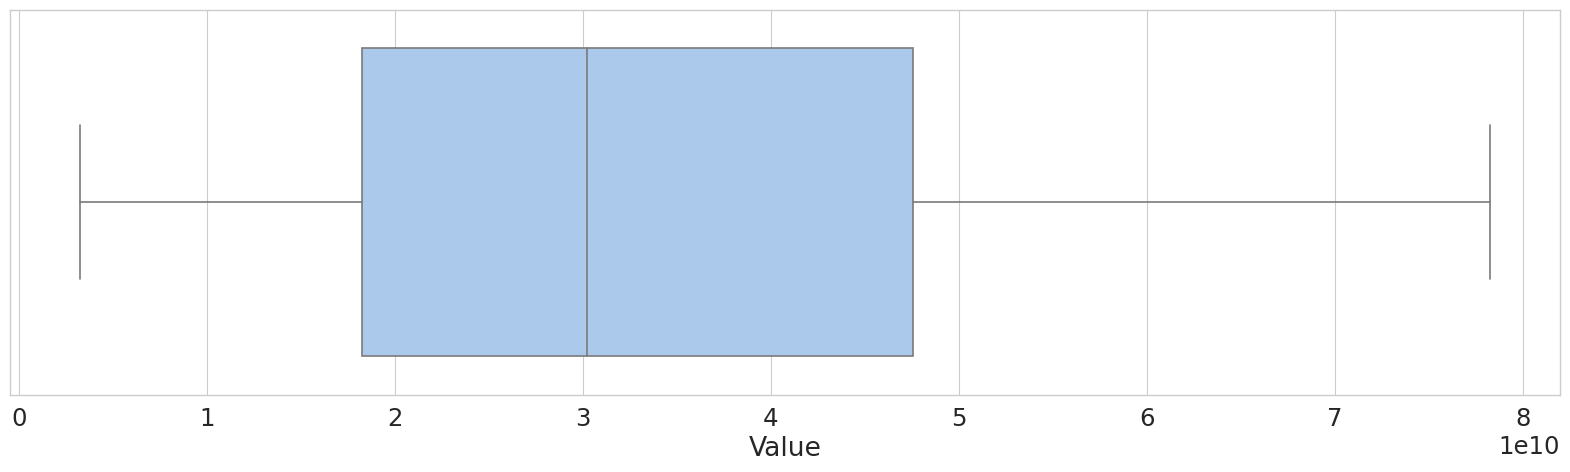

In [127]:
sns.boxplot(x = df_train['Value'], palette = 'pastel')

## Frequency table.

In [128]:
frequency_table = pd.cut(x = df_train['Value'], bins = 10).value_counts(sort = False)
print(frequency_table)

(3207863973.308, 10777388631.2]    125
(10777388631.2, 18271967500.4]     406
(18271967500.4, 25766546369.6]     395
(25766546369.6, 33261125238.8]     212
(33261125238.8, 40755704108.0]     239
(40755704108.0, 48250282977.2]     226
(48250282977.2, 55744861846.4]     139
(55744861846.4, 63239440715.6]     154
(63239440715.6, 70734019584.8]     159
(70734019584.8, 78228598454.0]      56
Name: Value, dtype: int64


## Визуализация распределения данных.

<AxesSubplot: xlabel='Value', ylabel='Count'>

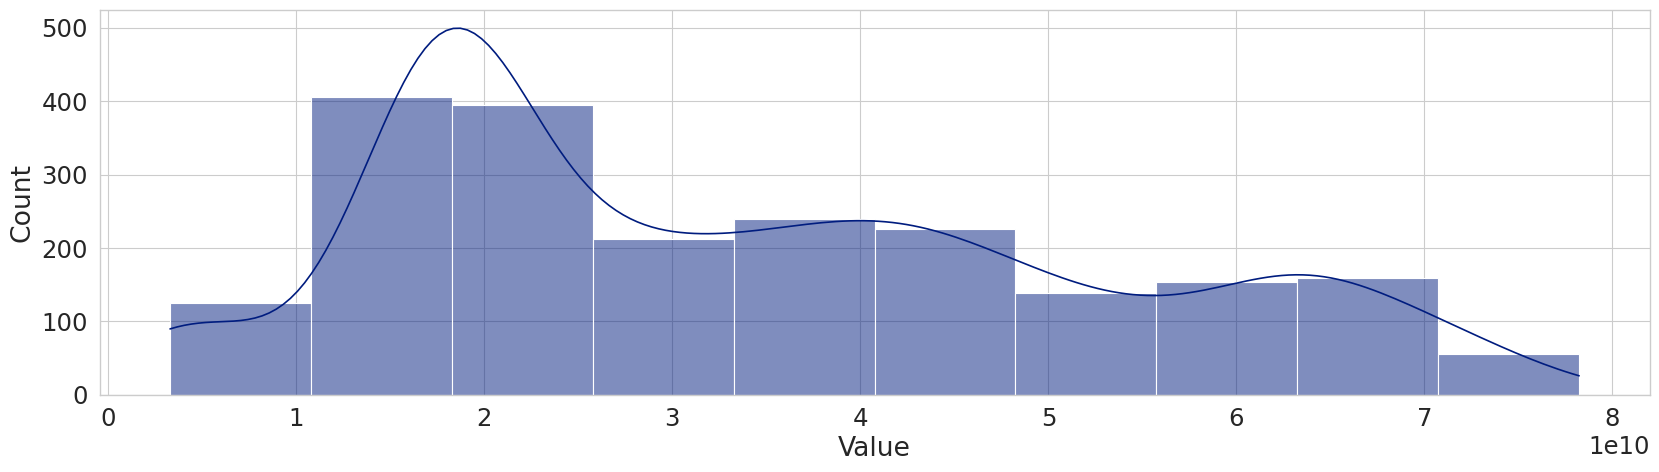

In [129]:
sns.histplot(x = df_train['Value'], bins = 10, kde = True)

# Корреляция.

<AxesSubplot: >

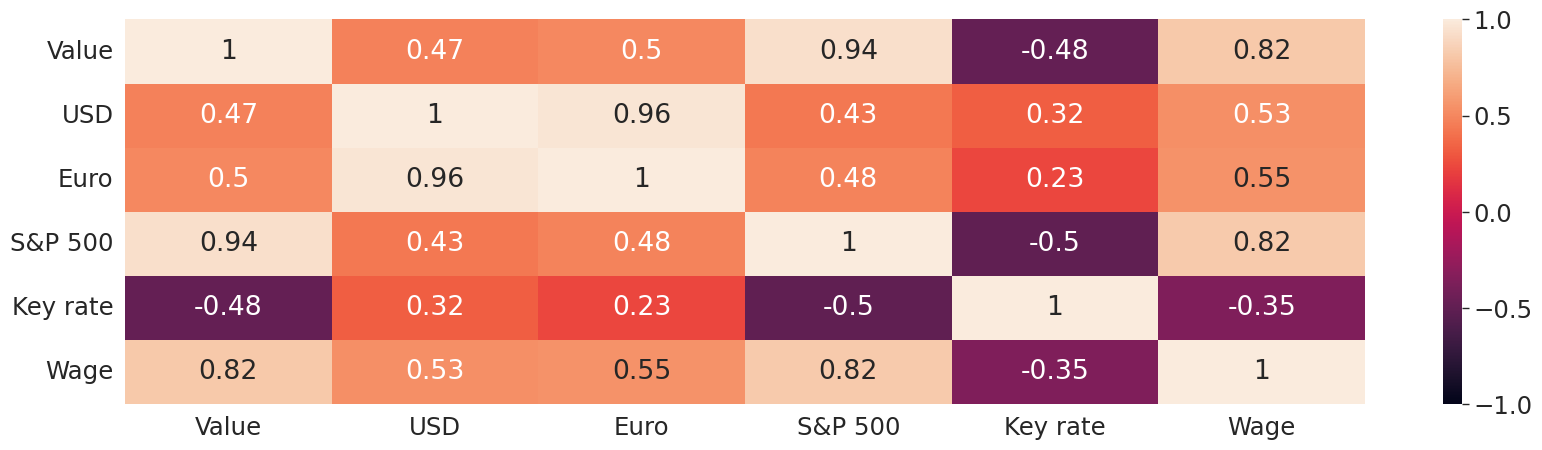

In [130]:
sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, annot = True)

### Слишком высокая корреляция (0.94) между индексом S&P 500 и объёмом средств показалась мне странной. Построив график зависимости одной переменной от другой, можно действительно убедиться, что при росте индекса S&P 500, растёт объём средств.

<AxesSubplot: xlabel='Value', ylabel='S&P 500'>

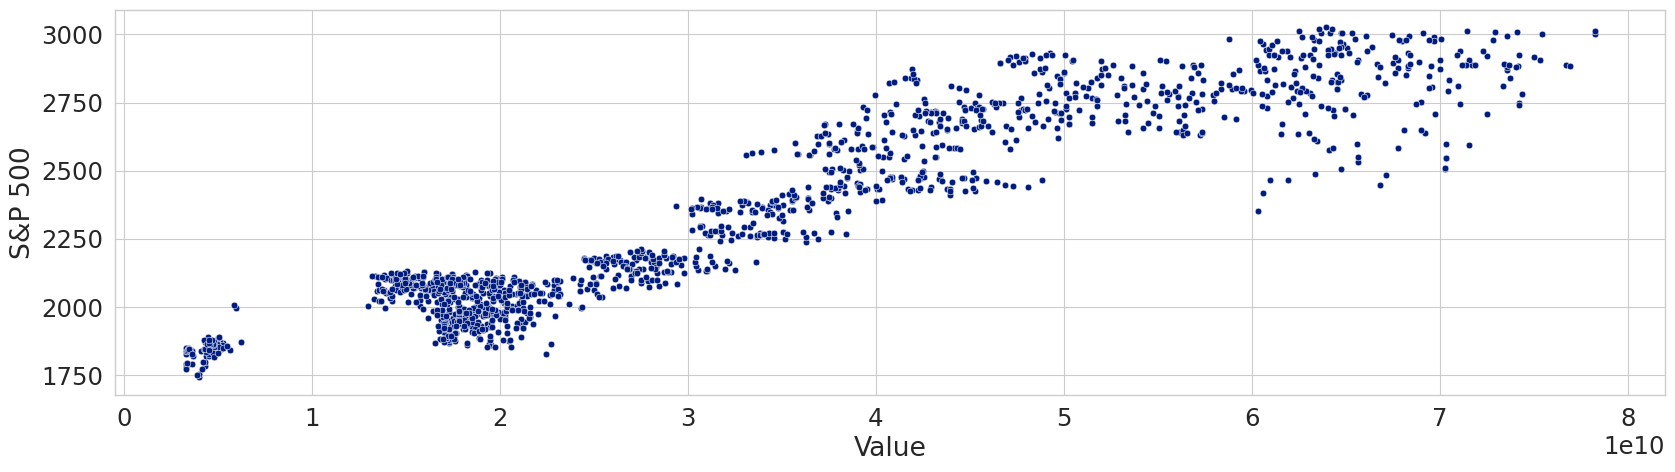

In [131]:
sns.scatterplot(x = df_train['Value'], y = df_train['S&P 500'])

# Feautre engineering.
## Заполнение пустых значений.

In [132]:
df_train['USD'] = df_train['USD'].groupby(by = [df_train.index.year, df_train.index.month],
                                          group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_train['Euro'] = df_train['Euro'].groupby(by = [df_train.index.year, df_train.index.month],
                                            group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_train['S&P 500'] = df_train['S&P 500'].groupby(by = [df_train.index.year, df_train.index.month],
                                                  group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_train['Key rate'].fillna(method = 'pad', inplace = True)
df_train['Key rate'].fillna(method = 'backfill', inplace = True)

df_train['Wage'].fillna(method = 'pad', inplace = True)
df_train['Wage'].fillna(method = 'backfill', inplace = True)

## Разбивка данных на тренировочную и тестируемую выборку.

In [133]:
x = df_train.drop(['Value'], axis = 1)
y = df_train['Value']

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1 / 3, random_state = 20, shuffle = True)

# Работа с моделью.
## Создание и обучение модели.

In [135]:
xgbr = xgb.XGBRegressor()

In [136]:
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Оценка работы модели.

In [137]:
r2 = r2_score(y_test, xgbr.predict(x_test))
MedianAE = median_absolute_error(y_test, xgbr.predict(x_test))
MeanAE = mean_absolute_error(y_test, xgbr.predict(x_test))

print(f"Coefficient of determination (R^2) = {r2}\nMedian absolute error = {MedianAE}\nMean absolute error = {MeanAE}")

Coefficient of determination (R^2) = 0.972153485474046
Median absolute error = 1250041868.5
Mean absolute error = 2077727727.3579545


# Попытка оценить объём стабильной части средств на каждое 1 число в течении 12 месяцев, начиная с 01.01.2020.
## Создание пустого датафрейма с необходимым диапазоном месяцев.

In [138]:
df_test = pd.DataFrame(index = pd.date_range(start = '01-01-2020', end = '12-01-2020', freq = 'D'))

## Правка данных.
### df_sp500.

In [139]:
df_sp500_test = df_sp500[(df_sp500['Report date'] >= pd.to_datetime('2020-01-01')) &
                         (df_sp500['Report date'] <= pd.to_datetime('2020-12-01'))]

df_sp500_test.set_index('Report date', inplace = True)

df_sp500_test.shape

(232, 1)

### df_usd.

In [140]:
df_usd_test = df_usd[(df_usd['Report date'] >= pd.to_datetime('2020-01-01')) &
                     (df_usd['Report date'] <= pd.to_datetime('2020-12-01'))]

df_usd_test.set_index('Report date', inplace = True)

df_usd_test.shape

(221, 1)

### df_euro.

In [141]:
df_euro_test = df_euro[(df_euro['Report date'] >= pd.to_datetime('2020-01-01'))&
                       (df_euro['Report date'] <= pd.to_datetime('2020-12-01'))]
    
df_euro_test.set_index('Report date', inplace = True)

df_euro_test.shape

(221, 1)

### df_kr.

In [142]:
df_kr_test = df_kr[(df_kr['Report date'] >= pd.to_datetime('2020-01-01')) &
                   (df_kr['Report date'] <= pd.to_datetime('2020-12-01'))]

df_kr_test.set_index('Report date', inplace = True)

df_kr_test.shape

(12, 1)

### df_wage.

In [143]:
df_wage_test = df_wage[(df_wage['Report date'] >= pd.to_datetime('2020-01-01')) &
                       (df_wage['Report date'] <= pd.to_datetime('2020-12-01'))]

df_wage_test.set_index('Report date', inplace = True)

df_wage_test.shape

(12, 1)

## Связка всех данных в один датафрейм.

In [144]:
df_test = df_usd_test.join([df_euro_test, df_sp500_test, df_kr_test, df_wage_test], how = 'outer')

df_test.shape

(282, 5)

## Feautre engineering.
### Заполнение пустых значений.

In [145]:
df_test['USD'] = df_test['USD'].groupby(by = [df_test.index.year, df_test.index.month],
                                        group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_test['Euro'] = df_test['Euro'].groupby(by = [df_test.index.year, df_test.index.month],
                                          group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_test['S&P 500'] = df_test['S&P 500'].groupby(by = [df_test.index.year, df_test.index.month],
                                                group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_test['Key rate'].fillna(method = 'pad', inplace = True)

df_test['Wage'].fillna(method = 'pad', inplace = True)

## Работа с моделью.
### Прогнозирование модели.

In [146]:
x_test = df_test[df_test.index.day == 1]
predicted_data = xgbr.predict(x_test)

## Прогнозируемый объём средств на каждое 1 число в течение 12 месяцев.

In [147]:
df_output = pd.DataFrame(data = predicted_data, index = x_test.index, columns = ['Predicted data'])
df_output

,Predicted data
Report date,
2020-01-01,4.570355e+10
2020-02-01,5.869289e+10
2020-03-01,6.316742e+10
2020-04-01,6.003471e+10
2020-05-01,6.750536e+10
2020-06-01,6.348877e+10
2020-07-01,6.343806e+10
2020-08-01,6.238110e+10
2020-09-01,6.262076e+10


### Визуализация прогнозируемого объёма.

<AxesSubplot: xlabel='Report date'>

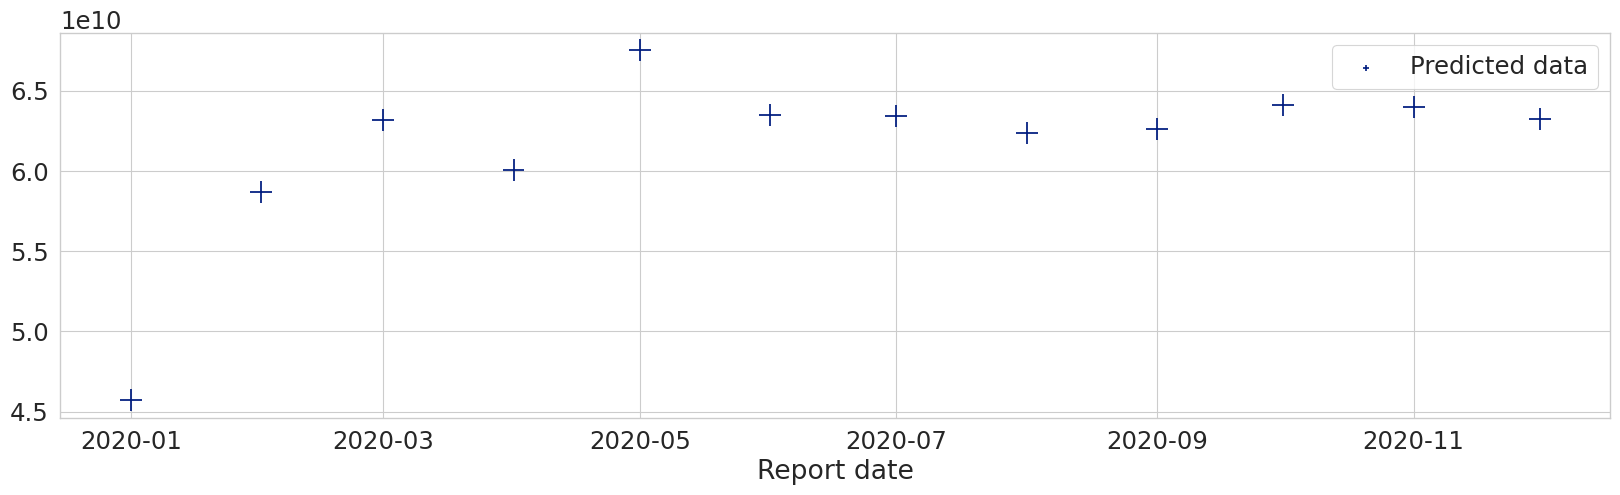

In [148]:
sns.scatterplot(df_output, markers = '+', s = 250)